In [2]:
# Install the 'contractions' library, which is used to expand contractions in English text (e.g., "don't" → "do not")
!pip install contractions


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 119.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.7 MB/s eta 0:00:00


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical


In [6]:

df = pd.read_csv('Emotion_final.csv', delimiter=',', encoding='latin-1', header=None)
df = df.rename(columns=lambda x: ['Sentence', 'Sentiment'][x])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21460 entries, 0 to 21459
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   21460 non-null  object
 1   Sentiment  21460 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


In [7]:
df = df.drop(index=0).reset_index(drop=True)

In [8]:
df = df[['Sentence', 'Sentiment']]
df.head()

,Sentence,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   21459 non-null  object
 1   Sentiment  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


Sentiment Class Distribution:
happy: 7029
sadness: 6265
anger: 2993
fear: 2652
love: 1641
surprise: 879


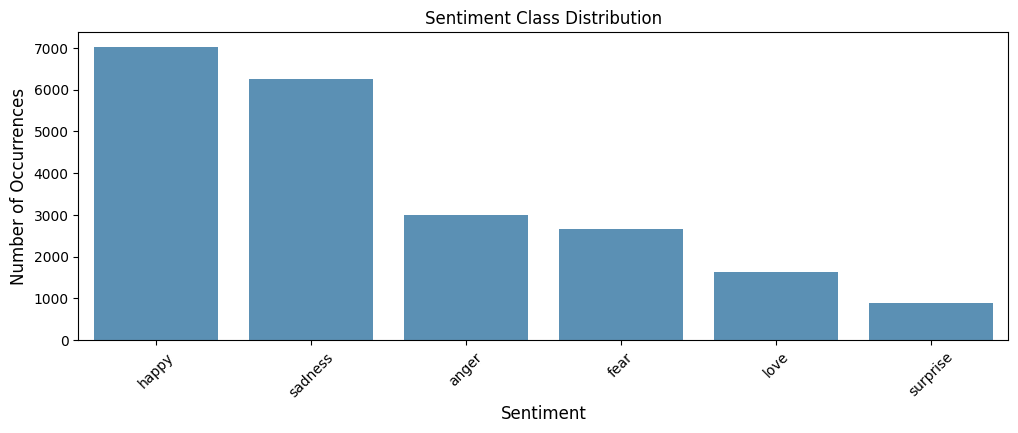

In [10]:

# Count sentiment occurrences
sentiment = df['Sentiment'].value_counts()

# Print all classes and their counts
print("Sentiment Class Distribution:")
for label, count in sentiment.items():
    print(f"{label}: {count}")

# Plot
plt.figure(figsize=(12, 4))
sns.barplot(x=sentiment.index, y=sentiment.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.title('Sentiment Class Distribution')
plt.show()


In [11]:
df.head()

,Sentence,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [15]:
def upsample_all_classes(df, label_column):
    # Separate by class
    grouped = [group for _, group in df.groupby(label_column)]

    # Find the largest class size
    max_size = max([len(group) for group in grouped])

    # Upsample each group
    upsampled = [
        resample(group, replace=True, n_samples=max_size, random_state=42)
        for group in grouped
    ]

    # Combine all upsampled groups
    df_upsampled = pd.concat(upsampled).sample(frac=1, random_state=42).reset_index(drop=True)

    return df_upsampled


In [16]:
df_balanced = upsample_all_classes(df, label_column='Sentiment')

In [17]:
print(df_balanced['Sentiment'].value_counts())

Sentiment
love        7029
happy       7029
anger       7029
sadness     7029
fear        7029
surprise    7029
Name: count, dtype: int64


In [20]:
from sklearn.model_selection import train_test_split  # Import function to split data into training and test sets

# Split the dataset into training and test sets
# - df_balanced.Sentence is the feature (input)
# - df_balanced.Sentiment is the target (label)
# - test_size=0.3 means 30% of the data is used for testing, 70% for training
# - random_state=42 ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.Sentence,
    df_balanced.Sentiment,
    test_size=0.3,
    random_state=42
)

# Check the shape (number of samples) in each of the resulting splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((29521,), (12653,), (29521,), (12653,))

In [22]:

token = Tokenizer()
token.fit_on_texts(X_train)

In [23]:
vocab = len(token.index_word) + 1
print("Vocabulary size={}".format(len(token.word_index)))
print("Number of Documents={}".format(token.document_count))

Vocabulary size=15422
Number of Documents=29521


In [24]:
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)

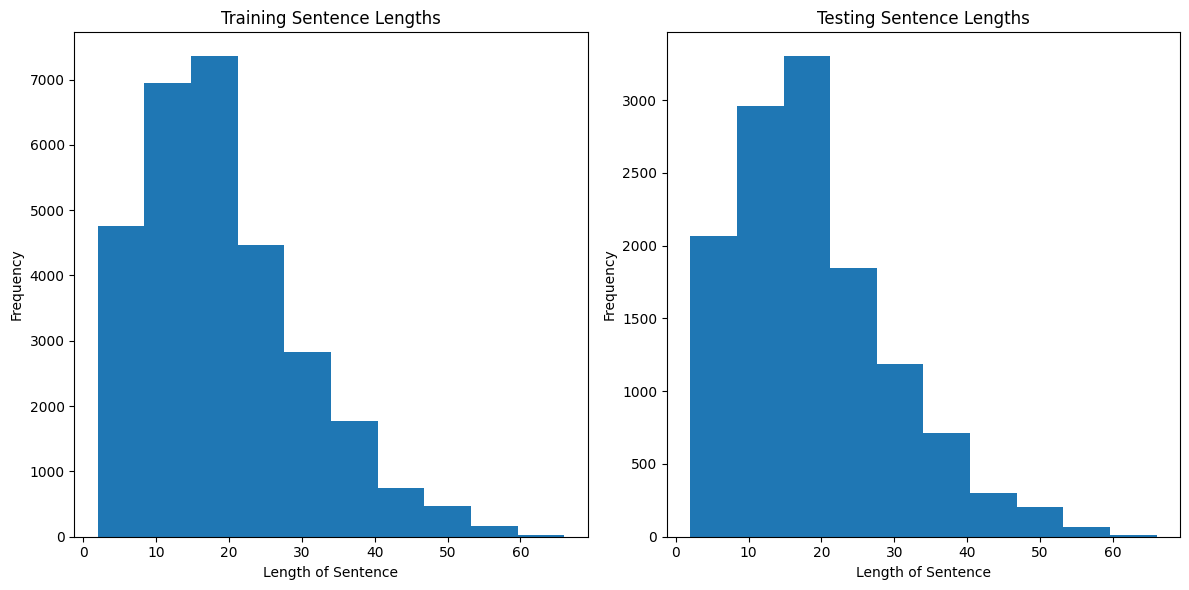

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Training set
ax[0].hist(train_lens)
ax[0].set_title('Training Sentence Lengths')
ax[0].set_xlabel('Length of Sentence')
ax[0].set_ylabel('Frequency')

# Testing set
ax[1].hist(test_lens)
ax[1].set_title('Testing Sentence Lengths')
ax[1].set_xlabel('Length of Sentence')
ax[1].set_ylabel('Frequency')

plt.tight_layout()  # Fix layout to show labels properly
plt.show()


In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Import function to pad sequences to the same length

# Define the maximum sequence length for padding
MAX_SEQUENCE_LENGTH = 30

# Pad the training sequences to the same length
# - padding="post" adds zeros to the end of the sequences if they're shorter than MAX_SEQUENCE_LENGTH
# - Sequences longer than MAX_SEQUENCE_LENGTH will be truncated from the end
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding="post")

# Pad the test sequences similarly
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding="post")

# Display the new shapes of the padded training and test sets
X_train.shape, X_test.shape


((29521, 30), (12653, 30))

In [27]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize a LabelEncoder to convert text labels into integers
le = LabelEncoder()

# Fit the encoder on training labels and transform them to integers
y_train_enc = le.fit_transform(y_train)

# Transform test labels using the same encoder (no fitting on test data!)
y_test_enc = le.transform(y_test)

# Optional: One-hot encode the integer labels for use with softmax output layers
y_train_cat = to_categorical(y_train_enc)  # Shape: (num_samples, num_classes)
y_test_cat = to_categorical(y_test_enc)

# Determine the number of unique sentiment classes
num_classes = len(le.classes_)
print("Number of sentiment classes:", num_classes)

# 🔍 Print the mapping between original sentiment labels and their encoded integer values
print("\nLabel Encoding Mapping:")
for idx, label in enumerate(le.classes_):
    print(f"{label} → {idx}")


Number of sentiment classes: 6

Label Encoding Mapping:
anger → 0
fear → 1
happy → 2
love → 3
sadness → 4
surprise → 5


In [28]:
# Encode the training labels into integers using LabelEncoder
y_train = le.fit_transform(y_train)  # Fit on training labels and transform them

# Encode the test labels using the same label encoder (don't fit again!)
y_test = le.transform(y_test)  # Transform test labels using the already-fitted encoder


In [29]:
y_train

array([2, 1, 2, ..., 5, 4, 0])

In [30]:
y_test

array([4, 3, 3, ..., 3, 4, 0])

In [31]:
# One-hot encode the labels
# Ensures labels are in a format suitable for categorical crossentropy loss (one-hot encoded)
y_train_cat = to_categorical(y_train, num_classes=6)
y_test_cat = to_categorical(y_test, num_classes=6)

# Define the size of the word embedding vectors
vec_size = 300

# Build the CNN model
model = Sequential()

# Add an Embedding layer to convert word indices to dense vectors
# - input_dim: total number of unique tokens (vocab size)
# - output_dim: dimension of the embedding vectors
# - input_length: fixed length of each input sequence
model.add(Embedding(input_dim=vocab, output_dim=vec_size, input_length=MAX_SEQUENCE_LENGTH))

# Add a 1D Convolutional layer
# - 64 filters
# - kernel size of 8 (i.e., looks at 8-word windows)
# - ReLU activation
model.add(Conv1D(64, kernel_size=8, activation="relu"))

# Downsample the output using max pooling (to reduce dimensionality)
model.add(MaxPooling1D(pool_size=2))

# Add dropout for regularization (prevents overfitting)
model.add(Dropout(0.1))

# Fully connected Dense layers with ReLU activation
model.add(Dense(8, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.1))

# Use Global Max Pooling to reduce sequence output to a single vector
model.add(GlobalMaxPooling1D())

# Final Dense layer with softmax activation for multi-class classification (6 classes)
model.add(Dense(6, activation='softmax'))

# Compile the model
# - Loss: categorical crossentropy for multi-class classification
# - Optimizer: Adam with a low learning rate
# - Metrics: track accuracy during training and evaluation
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Force model building with specific input shape to ensure .summary() works correctly
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

# Display the model architecture summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 30, 300)        │     4,626,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 23, 64)         │       153,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11, 8)          │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11, 4)          │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 11, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 4)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,781,150 (18.24 MB)

 Trainable params: 4,781,150 (18.24 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Fit (train) the model on the training data
# - X_train: padded input sequences
# - y_train_cat: one-hot encoded training labels
# - validation_data: used to evaluate the model on unseen test data after each epoch
# - batch_size: number of samples per gradient update
# - epochs: number of complete passes through the training data
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    batch_size=64,
    epochs=10
)


Epoch 1/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 75s 158ms/step - accuracy: 0.1887 - loss: 1.7883 - val_accuracy: 0.2550 - val_loss: 1.7565
Epoch 2/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 71s 154ms/step - accuracy: 0.2627 - loss: 1.6838 - val_accuracy: 0.5383 - val_loss: 1.4347
Epoch 3/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 70s 153ms/step - accuracy: 0.4914 - loss: 1.3773 - val_accuracy: 0.6487 - val_loss: 1.1021
Epoch 4/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 71s 154ms/step - accuracy: 0.5935 - loss: 1.0835 - val_accuracy: 0.7250 - val_loss: 0.9019
Epoch 5/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 71s 155ms/step - accuracy: 0.7138 - loss: 0.8894 - val_accuracy: 0.8738 - val_loss: 0.7311
Epoch 6/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 71s 153ms/step - accuracy: 0.8486 - loss: 0.6991 - val_accuracy: 0.9038 - val_loss: 0.5421
Epoch 7/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 71s 153ms/step - accuracy: 0.8843 - loss: 0.5120 - val_accuracy: 0.9219 - val_loss: 0.4019
Epoch 8/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 71s 154ms/step - accuracy: 0.9087 - loss: 0

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict on the test set
y_pred_probs = model.predict(X_test)              # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)          # Get predicted class indices
y_true = np.argmax(y_test_cat, axis=1)            # Get true class indices

# Step 2: Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred))

396/396 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2151
           1       0.91      0.92      0.92      2080
           2       0.96      0.90      0.93      2094
           3       0.95      0.98      0.96      2099
           4       0.94      0.88      0.91      2064
           5       0.95      0.99      0.97      2165

    accuracy                           0.94     12653
   macro avg       0.94      0.94      0.94     12653
weighted avg       0.94      0.94      0.94     12653



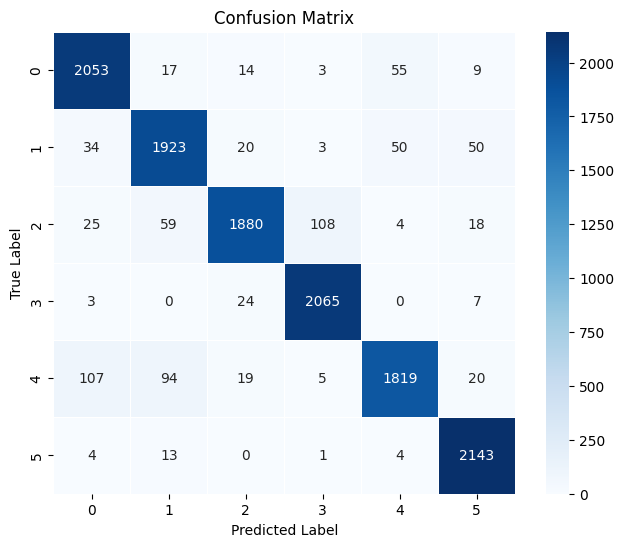

In [35]:

cm = confusion_matrix(y_true, y_pred)             # Compute the confusion matrix
plt.figure(figsize=(8, 6))                        # Set figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True, linewidths=0.5)
plt.title('Confusion Matrix')                     # Set plot title
plt.xlabel('Predicted Label')                     # Label x-axis
plt.ylabel('True Label')                          # Label y-axis
plt.show()

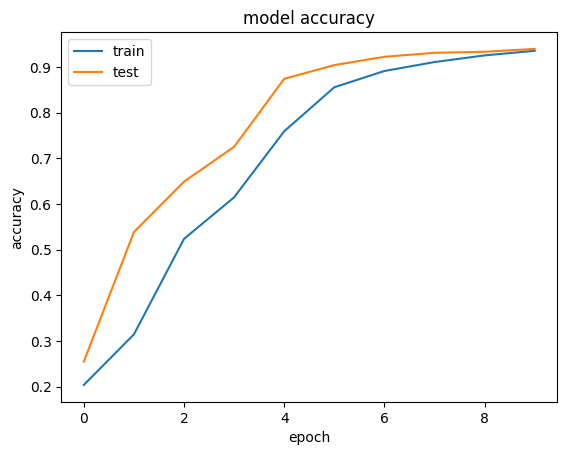

In [36]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

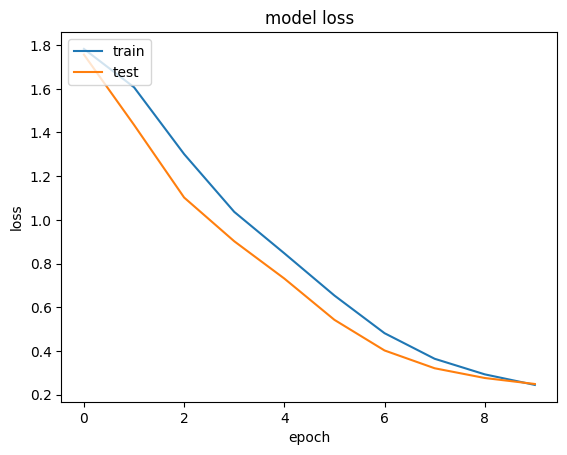

In [37]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# New example sentences to classify
example_texts = [
    "I can't wait to see my friends again, I'm so excited!",  # Likely 'happy' or 'love'
    "I'm terrified about the future, it's all so uncertain.",  # Likely 'fear'
    "I feel completely heartbroken after what happened.",       # Likely 'sadness'
    "This is outrageous, how could they do this to me!"         # Likely 'anger'
]

# Tokenize the input examples using the same tokenizer used during training
example_seqs = token.texts_to_sequences(example_texts)

# Pad the sequences to the same length as during training
MAX_SEQUENCE_LENGTH = 30
example_padded = pad_sequences(example_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Predict sentiment probabilities
example_preds_probs = model.predict(example_padded)  # Shape: (n_samples, n_classes)

# Get predicted class indices
example_preds = np.argmax(example_preds_probs, axis=1)

# Convert predicted indices back to sentiment labels
predicted_labels = le.inverse_transform(example_preds)

# Map indices to emotion labels
emotion_map = {
    0: 'anger',
    1: 'fear',
    2: 'happy',
    3: 'love',
    4: 'sadness',
    5: 'surprise'
}

# Print results with probabilities in standard decimal notation (10 decimal places)
for i, text in enumerate(example_texts):
    predicted_emotion = emotion_map[example_preds[i]]

    # Format each probability as a string with exactly 10 digits after the decimal
    confidence_scores = [f"{prob:.10f}" for prob in example_preds_probs[i]]

    print(f"Input: {text}")
    print(f"Predicted Emotion: {predicted_emotion}")
    print(f"Confidence Scores: {confidence_scores}")
    print("-" * 50)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Input: I can't wait to see my friends again, I'm so excited!
Predicted Emotion: happy
Confidence Scores: ['0.0024632558', '0.0289774369', '0.7873230577', '0.1762249321', '0.0007976022', '0.0042137862']
--------------------------------------------------
Input: I'm terrified about the future, it's all so uncertain.
Predicted Emotion: fear
Confidence Scores: ['0.0000025945', '0.9790837169', '0.0019920450', '0.0000467690', '0.0178940203', '0.0009809037']
--------------------------------------------------
Input: I feel completely heartbroken after what happened.
Predicted Emotion: sadness
Confidence Scores: ['0.0012430854', '0.0066209934', '0.0000000011', '0.0000000025', '0.9908917546', '0.0012441510']
--------------------------------------------------
Input: This is outrageous, how could they do this to me!
Predicted Emotion: anger
Confidence Scores: ['0.4419621527', '0.0866722241', '0.0535537489', '0.0551868565', '0.2422245443', '0.1204004288']
------

In [43]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Four example paragraphs with different sentiments
example_texts = [
    "I just received some wonderful news! I got the job I applied for, and I feel so excited and thankful for this opportunity. It's a huge step forward in my career, and I can't wait to start this new chapter of my life.",  # Likely 'happy'

    "There's so much uncertainty in the world right now. I worry about my family and the future. The constant anxiety is affecting me, and I don't know what will happen next. I'm scared of what might come.",  # Likely 'fear'

    "I can't believe what they did! They betrayed my trust in the worst possible way. How could they do this to me? I'm furious and feel completely disrespected by their actions. I never expected this kind of treatment from them.",  # Likely 'anger'
]

# Tokenize the input examples (use the same tokenizer fitted on the training data)
example_seqs = token.texts_to_sequences(example_texts)

# Pad the sequences to ensure they match the input size used during training
MAX_SEQUENCE_LENGTH = 30  # Same as used for training
example_padded = pad_sequences(example_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Predict sentiment for the examples
example_preds_probs = model.predict(example_padded)  # Get predicted probabilities
example_preds = np.argmax(example_preds_probs, axis=1)  # Get predicted class indices

# Convert predicted indices back to sentiment labels
predicted_labels = le.inverse_transform(example_preds)

# Sentiment classes (emotions) according to your original LabelEncoder
emotion_map = {
    0: 'anger',
    1: 'fear',
    2: 'happy',
    3: 'love',
    4: 'sadness',
    5: 'surprise'
}

# Print results with probabilities in standard decimal notation (10 decimal places)
for i, text in enumerate(example_texts):
    predicted_emotion = emotion_map[example_preds[i]]

    # Format each probability as a string with exactly 10 digits after the decimal
    confidence_scores = [f"{prob:.10f}" for prob in example_preds_probs[i]]

    print(f"Input: {text}")
    print(f"Predicted Emotion: {predicted_emotion}")
    print(f"Confidence Scores: {confidence_scores}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Input: I just received some wonderful news! I got the job I applied for, and I feel so excited and thankful for this opportunity. It's a huge step forward in my career, and I can't wait to start this new chapter of my life.
Predicted Emotion: happy
Confidence Scores: ['0.0000043361', '0.0014152934', '0.9367918968', '0.0617637299', '0.0000004232', '0.0000243665']
--------------------------------------------------
Input: There's so much uncertainty in the world right now. I worry about my family and the future. The constant anxiety is affecting me, and I don't know what will happen next. I'm scared of what might come.
Predicted Emotion: fear
Confidence Scores: ['0.0065202080', '0.4807519019', '0.3753847182', '0.0608618483', '0.0452273153', '0.0312540643']
--------------------------------------------------
Input: I can't believe what they did! They betrayed my trust in the worst possible way. How could they do this to me? I'm furious and feel complete

In [44]:
from tensorflow.keras.models import save_model, load_model
import pickle

# Save the model
model.save("emotion_model.h5")

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(token, f)

# Save the label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


In [46]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import numpy as np

# Load the model
model = load_model("emotion_model.h5")

# Load tokenizer
with open("tokenizer.pkl", "rb") as f:
    token = pickle.load(f)

# Load label encoder
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# Define your new texts
example_texts = [
    "I can't wait to see my friends again, I'm so excited!",
    "I'm terrified about the future, it's all so uncertain.",
    "I feel completely heartbroken after what happened.",
    "This is outrageous, how could they do this to me!"
]

# Preprocess: tokenize and pad
MAX_SEQUENCE_LENGTH = 30
example_seqs = token.texts_to_sequences(example_texts)
example_padded = pad_sequences(example_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Predict
example_preds_probs = model.predict(example_padded)
example_preds = np.argmax(example_preds_probs, axis=1)
predicted_labels = le.inverse_transform(example_preds)

# Print results with probabilities in standard decimal notation (10 decimal places)
for i, text in enumerate(example_texts):
    predicted_emotion = emotion_map[example_preds[i]]

    # Format each probability as a string with exactly 10 digits after the decimal
    confidence_scores = [f"{prob:.10f}" for prob in example_preds_probs[i]]

    print(f"Input: {text}")
    print(f"Predicted Emotion: {predicted_emotion}")
    print(f"Confidence Scores: {confidence_scores}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Input: I can't wait to see my friends again, I'm so excited!
Predicted Emotion: happy
Confidence Scores: ['0.0024632558', '0.0289774369', '0.7873230577', '0.1762249321', '0.0007976022', '0.0042137862']
--------------------------------------------------
Input: I'm terrified about the future, it's all so uncertain.
Predicted Emotion: fear
Confidence Scores: ['0.0000025945', '0.9790837169', '0.0019920450', '0.0000467690', '0.0178940203', '0.0009809037']
--------------------------------------------------
Input: I feel completely heartbroken after what happened.
Predicted Emotion: sadness
Confidence Scores: ['0.0012430854', '0.0066209934', '0.0000000011', '0.0000000025', '0.9908917546', '0.0012441510']
--------------------------------------------------
Input: This is outrageous, how could they do this to me!
Predicted Emotion: anger
Confidence Scores: ['0.4419621527', '0.0866722241', '0.0535537489', '0.0551868565', '0.2422245443', '0.1204004288']
------